In [5]:
import sys
import os
import math
import csv
import numpy as np
import torch

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome

In [6]:
vg = VisualGenome()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...
Data loaded.


In [4]:
# get all the relationships in "object predicate subject" format with image id and relationship id

relationships = []
for im in vg.get_images():
    rels = vg.get_image_relationships(im)
    for rel in rels:
        dict_ = {
            "image_id": im,
            "relationship_id": rel.id,
            "object": rel.object_name.replace(",", ""),
            "predicate": rel.predicate.replace(",", ""),
            "subject": rel.subject_name.replace(",", "")
        }
        relationships.append(dict_)


# surprisal vs. lm-scorer vs. minicons

To get surprisal values and make experiments using language models, there seems to be three main libraries that can be used: [surprisal](https://github.com/aalok-sathe/surprisal), [lm-scorer](https://github.com/simonepri/lm-scorer) and [minicons](https://github.com/kanishkamisra/minicons). `lm-scorer` is an old library and it is not maintained anymore. I couldn't make it work due to some dependency issues. `surprisal` is implemented inspired by `lm-scorer` and their surprisal outputs seem to match (based on the input sentences provided in `lm-scorer` repository). However, masked language models are not supported in `surprisal`. `minicons` supports both auto-regressive and masked language models and it is actively maintained. So, I decided to use `minicons` for this notebook. 

In its default usage, `minicons` produces slightly different surprisal values compared to `surprisal` and `lm-scorer`. It is discussed in detail in the following issue: https://github.com/kanishkamisra/minicons/issues/29 

To put it simply, main difference is that `minicons`, by default, ignores the first token and starts calculating the probabilities by the second token $p(w_1| w_0)$. `lm-scorer` on the other hand, calculates the probability of the first token as well using $p(w_0| \text{<|endoftext|>})$. According to the claim made by the author of `minicons`, his approach is more consistent with how people are doing experiments in psycholinguistics. To completely match with the probabilities produced by `lm-scorer`, one can use the `bos_token=True, eos_token=False` parameters in `minicons`.


In [4]:
# write relationships to csv
def write(relationships, filename = 'relationships', sort='average surprisal'):
    # sort the relationships by average surprisal
    relationships = sorted(relationships, key=lambda x: (x[sort] is None, x[sort]))
    
    trynext = False
    with open(f'{filename}.csv', 'w', newline="") as f:
        field_order = ['image_id', 'relationship_id', 'subject', 'predicate', 'object', 'average surprisal']
        if 'predicate_surprisal' in relationships[0]:
            field_order.extend(['predicate_surprisal', 'subject_surprisal', 'object_surprisal'])
        writer = csv.DictWriter(f, field_order)
        writer.writeheader()
        writer.writerows(relationships)
   

    # write relationships to json
    import json

    
    with open(f'{filename}.json', 'w') as f:
        json.dump(relationships, f)
        

    # write relationships to txt
    if trynext:
        try:
            with open(f'{filename}.txt', 'w') as f:
                for rel in relationships:
                    f.write(f"{rel['image_id']} {rel['relationship_id']} {rel['subject']} {rel['predicate']} {rel['object']} {rel['average , newsurprisal']}\n")
        except:
            print("Error writing to txt")
            trynext = True

## Causal Surprisal (minicons)

Python package [minicons] supports both causal and masked surprisal. Make sure the package is installed.
```bash
pip install minicons
```

In [5]:
from minicons import scorer

ilm_model = scorer.IncrementalLMScorer('gpt2', 'cuda') 

sentences = ["I like this package."]
print(ilm_model.sequence_score(sentences, reduction = lambda x: -x.mean(0).item())) # average surprisal of the sequence (normalized by sequence length)

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp

[4.620823860168457]


In [10]:
def get_sentences(relationships):
    sentences = []
    for rel in relationships:
        sentence = f"{rel['subject']} {rel['predicate']} {rel['object']}"
        sentences.append(sentence)
    return sentences

def get_surprisals(relationships, sentences, model, PLL_metric = 'within_word_l2r', batch_size=256):
    num_batches = math.ceil(len(sentences) / batch_size)
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        batch = sentences[start:end]
        if(isinstance(model, scorer.IncrementalLMScorer)):
            # take max
            results = model.sequence_score(batch, reduction = lambda x: -x.max(0)[0].item())
            # results = model.sequence_score(batch, reduction = lambda x: -x.mean(0).item()) # average surprisal of the sequence (normalized by sequence length)
        elif(isinstance(model, scorer.MaskedLMScorer)):
            results = model.sequence_score(batch, reduction = lambda x: -x.max(0)[0].item())
            # results = model.sequence_score(batch, reduction = lambda x: -x.mean(0).item(), PLL_metric=PLL_metric)
        else:
            print("Model not recognized")
            return
            
        for i, rel in enumerate(relationships[start:end]):
            rel['average surprisal'] = results[i]
    return relationships

In [11]:
sentences = get_sentences(relationships)
relationships = get_surprisals(relationships, sentences, ilm_model)

In [12]:
write(relationships)

## Masked Surprisal (minicons)

In [23]:
mlm_model = scorer.MaskedLMScorer('bert-base-uncased', 'cuda') 

sentences = ["I like this package."]
print(mlm_model.sequence_score(sentences, reduction = lambda x: -x.mean(0).item(), PLL_metric='within_word_l2r'))

[2.4668994903564454]


In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

71

In [24]:
sentences = get_sentences(relationships)
relationships = get_surprisals(relationships, sentences, mlm_model, batch_size=64) # larger batch sizes do not fit in the memory

In [27]:
write(relationships,filename = "relationships (masked - minicons)")

## Masked Surprisal for Relationship (minicons)

In [89]:
mlm_model = scorer.MaskedLMScorer('bert-base-uncased', 'cuda') 

sentences = ["brown_grass"]

token_surprisals = mlm_model.token_score(sentences,  surprisal=True, PLL_metric='within_word_l2r')
token_surprisals

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[[('brown', 6.347966194152832),
  ('_', 12.027071952819824),
  ('grass', 19.709861755371094)]]

In [90]:
preprocess_sentence(sentences[0])

['brown_grass']

In [82]:
import re
def preprocess_sentence(sentence):
    # Split sentence into parts: separate punctuation, hyphenated words, and words with apostrophes
    processed_parts = []

    # Regular expression to match words, punctuation, and special cases
    pattern = re.compile(r"[\w]+|[.,!?;:'\"-_]")

    # Find all matches and add them to the processed list
    matches = pattern.findall(sentence)
    return matches


In [83]:
def tokens_to_words(tokens_with_surprisal):
    merged_list = []
    current_word = ""
    current_surprisals = []

    for token, surprisal in tokens_with_surprisal:
        if token.startswith('##'):
            # If the token starts with ##, it's part of the current word
            current_word += token[2:]
            current_surprisals.append(surprisal)
        else:
            # If we were building a word, finalize it
            if current_word:
                # Average surprisal for the previous word
                avg_surprisal = sum(current_surprisals) / len(current_surprisals)
                merged_list.append((current_word, avg_surprisal))
            # Start a new word
            current_word = token
            current_surprisals = [surprisal]

    # Add the last word being built
    if current_word:
        avg_surprisal = sum(current_surprisals) / len(current_surprisals)
        merged_list.append((current_word, avg_surprisal))

    return merged_list

In [84]:
def match_relations_to_surprisal(rel, word_surprisal_list):
    def find_surprisal(phrase, remaining_word_surprisal_list):
        words = preprocess_sentence(phrase)
        total_surprisal = 0
        matched_count = 0
        
        # Match each word in the phrase to the word_surprisal_list in order
        for word in words:
            for i, (token, surprisal) in enumerate(remaining_word_surprisal_list):
                if word == token:
                    total_surprisal += surprisal
                    matched_count += 1
                    # Remove the matched word from remaining list to avoid reusing it
                    remaining_word_surprisal_list.pop(i)
                    break  # Exit the inner loop once the word is matched
        
        # If no words matched, return None, otherwise return the average surprisal
        if matched_count == 0:
            print(f"Could not match any words in '{phrase}', relationship id: {rel['relationship_id']}")
            return None
        return total_surprisal / matched_count

    # Copy the word_surprisal_list to track remaining words after each match
    remaining_word_surprisal_list = word_surprisal_list[:]

    # Calculate the average surprisal for subject, predicate, and object
    subject_surprisal = find_surprisal(rel['subject'], remaining_word_surprisal_list)
    predicate_surprisal = find_surprisal(rel['predicate'], remaining_word_surprisal_list)
    object_surprisal = find_surprisal(rel['object'], remaining_word_surprisal_list)

    # Return the surprisals mapped to subject, predicate, and object
    return {
        'subject_surprisal': subject_surprisal,
        'predicate_surprisal': predicate_surprisal,
        'object_surprisal': object_surprisal
    }

In [ ]:
batch_size = 64
sentences = get_sentences(relationships)

num_batches = math.ceil(len(sentences) / batch_size)
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch = sentences[start:end]
    
    results = mlm_model.token_score(batch, surprisal=True, PLL_metric='within_word_l2r')     
    for i, rel in enumerate(relationships[start:end]):
        words_surprisals = tokens_to_words(results[i])
        surprisals = match_relations_to_surprisal(rel, words_surprisals)
        rel.update(surprisals)


In [5]:
def replace_special_characters(sentence):
    # Define a mapping of special characters to their English counterparts
    replacements = {
        'á': 'a',
        'é': 'e',
        'ç': 'c',
        'ÿ': 'y',
        'ñ': 'n'
    }
    
    # Use the translate method with a translation table created from the replacements dictionary
    translation_table = str.maketrans(replacements)
    
    # Replace special characters in the sentence
    return sentence.translate(translation_table)

In [94]:
for rel in relationships:
    rel['subject'] = replace_special_characters(rel['subject'])
    rel['predicate'] = replace_special_characters(rel['predicate'])
    rel['object'] = replace_special_characters(rel['object'])


In [103]:
write(relationships, filename = "relationships (masked - minicons - token)", sort='predicate_surprisal')

## Correlation

In [7]:
# read json relationships (incremental - minicons)
import json

with open('C:\\Users\\karab\\Desktop\\Storage for Visual Genome\\surprisals\\relationships (incremental - minicons).json', 'r') as f:
    relationships_incremental = json.load(f)
with open('C:\\Users\\karab\\Desktop\\Storage for Visual Genome\\surprisals\\relationships (masked - tokens).json', 'r') as f:
    relationships_masked = json.load(f)
with open('C:\\Users\\karab\\Desktop\\Storage for Visual Genome\\surprisals\\relationships (incremental - surprisal).json', 'r') as f:
    relationships_incremental_bos = json.load(f)
with open('C:\\Users\\karab\\Desktop\\Storage for Visual Genome\\surprisals\\relationships (masked).json', 'r') as f:
    relationships_masked_overall = json.load(f)

len(relationships_incremental), len(relationships_masked), len(relationships_incremental_bos), len(relationships_masked_overall)

(1498303, 1498303, 1498303, 1498303)

In [8]:
def calculate_image_surprisal(relationships, key='average surprisal', aggregation='average'):
    image_surprisal = {}
    for rel in relationships:
        image_id = rel['image_id']
        if image_id not in image_surprisal:
            image_surprisal[image_id] = []
        # Treat None as 0
        value = rel[key] if rel[key] is not None else 0
        image_surprisal[image_id].append(value)
    
    # Calculate the average, ignoring Nones which are treated as 0
    if aggregation == 'average':
        return {k: sum(v) / len(v) for k, v in image_surprisal.items()}
    elif aggregation == 'max':
        return {k: max(v) for k, v in image_surprisal.items()}
    else:
        raise ValueError(f"Invalid aggregation method: {aggregation}")    


In [9]:
image_surprisals = calculate_image_surprisal(relationships_incremental)

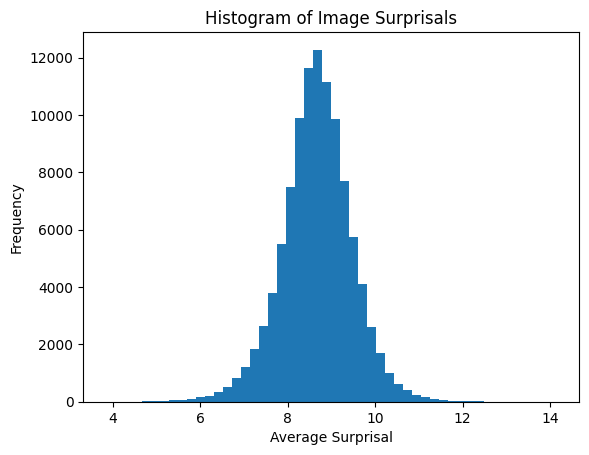

In [10]:
# histogram of image surprisals
import matplotlib.pyplot as plt

plt.hist(image_surprisals.values(), bins=50)
plt.xlabel('Average Surprisal')
plt.ylabel('Frequency')
plt.title('Histogram of Image Surprisals')
plt.show()


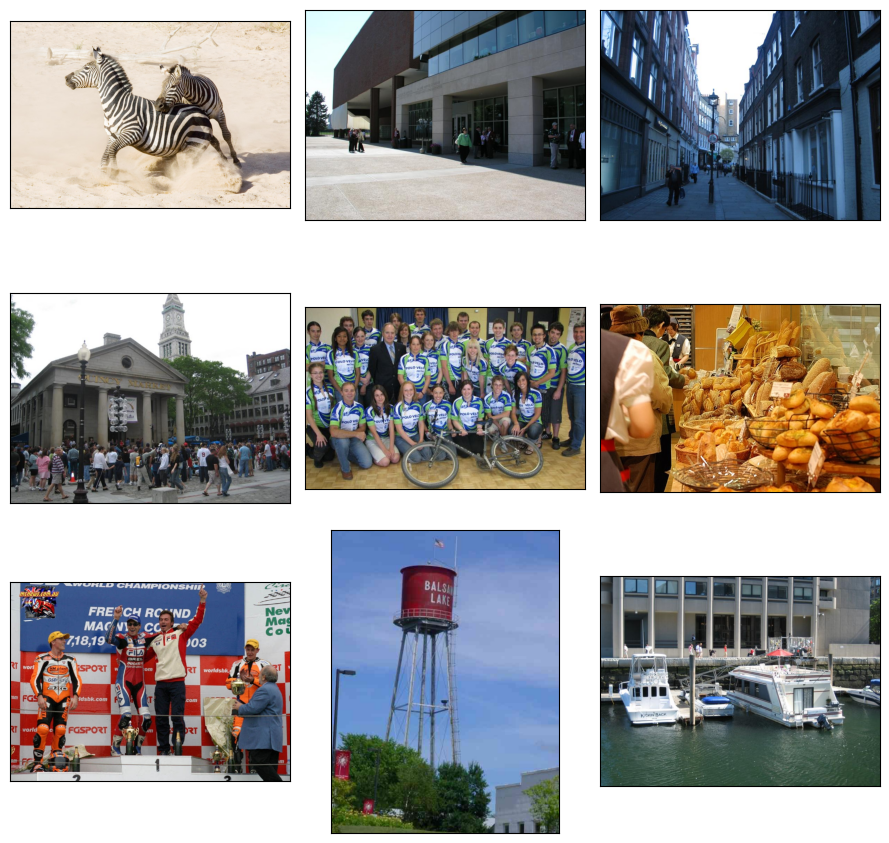

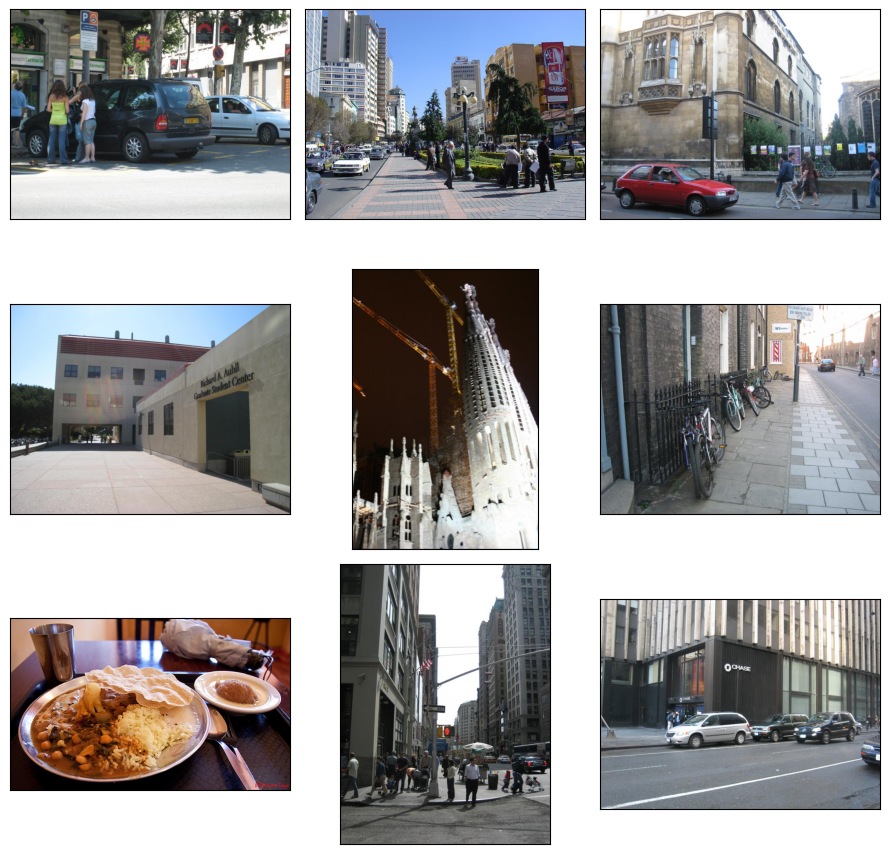

In [12]:
# sample 9 images with average surprisal < 6

low_surprisal_images = {k: v for k, v in image_surprisals.items() if v < 6}
high_surprisal_images = {k: v for k, v in image_surprisals.items() if v > 10}

low_sample_images = list(low_surprisal_images.keys())[:9]
high_sample_images = list(high_surprisal_images.keys())[:9]

vg.visualize_images_side_by_side(low_sample_images)
vg.visualize_images_side_by_side(high_sample_images)


In [15]:
# read features.csv
import pandas as pd

features = pd.read_csv('features.csv')

In [18]:
# merge features with image surprisals
features['image_id'] = features['image_id'].astype(int)
features = features.merge(pd.DataFrame(image_surprisals.items(), columns=['image_id', 'max_surprisal']), on='image_id')
features

,image_id,# of objects,# of attributes,# of relationships,# of regions,# of unique objects (synsets),# of unique attributes (synsets),# of unique relationships (synsets),Average attribute inverse frequency (synsets),Average object inverse frequency (synsets),...,# of FC-CLIP classes,average autoregressive surprisal,average masked surprisal,average masked surprisal for relationship predicate,|E|/|V| ratio,avg_region_similarity,avg_object_similarity,avg_rel_similarity,predicted_complexity,max_surprisal
0,1,31,32,18,262,25,17,6,0.132813,0.024155,...,13,8.608981,8.523191,4.205448,0.84,0.189724,0.259635,0.301131,0.6528,8.608981
1,2,25,30,22,256,17,16,8,0.010012,0.013396,...,14,9.189412,9.802080,6.370214,0.96,0.233120,0.313372,0.331084,0.5888,9.189412
2,3,37,19,41,255,30,12,10,0.260737,0.129121,...,13,8.418718,9.055690,5.919293,1.04,0.243013,0.270305,0.228097,0.5586,8.418718
3,4,23,44,14,257,21,27,7,0.307471,0.343975,...,11,9.227663,9.741917,5.280698,0.89,0.266600,0.312936,0.342171,0.5076,9.227663
4,5,31,29,22,248,25,14,5,0.221108,0.287152,...,22,8.978987,9.086364,4.162719,0.89,0.255778,0.294979,0.310770,0.5878,8.978987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104091,2417992,29,6,20,50,17,5,3,0.081030,0.069637,...,8,7.910824,10.422308,4.003699,0.84,0.438666,0.328183,0.520109,0.5900,7.910824
104092,2417993,20,9,7,49,15,5,3,0.002625,0.449414,...,6,8.641641,9.879321,5.500837,0.64,0.364019,0.283696,0.224723,0.3788,8.641641
104093,2417994,11,9,17,50,9,7,2,0.021752,0.035240,...,2,9.262178,11.308207,6.683035,1.16,0.440963,0.332056,0.466888,0.3936,9.262178
104094,2417995,26,10,3,50,10,6,3,0.136626,0.010861,...,5,9.482599,11.390144,6.454046,0.41,0.701256,0.541360,0.208929,0.5679,9.482599


In [21]:
# measure correlation between everything and predicted_complexity
correlation = features.corr()['predicted_complexity']
correlation


image_id                                              -0.130923
# of objects                                           0.295287
# of attributes                                        0.089867
# of relationships                                     0.058698
# of regions                                           0.109070
# of unique objects (synsets)                          0.230597
# of unique attributes (synsets)                       0.058082
# of unique relationships (synsets)                    0.027511
Average attribute inverse frequency (synsets)         -0.016443
Average object inverse frequency (synsets)             0.011077
Average relationship inverse frequency (synsets)       0.000447
# of SAM segmentations                                 0.783644
# of SAM 2 segmentations                               0.527158
# of FC-CLIP classes                                   0.543780
average autoregressive surprisal                      -0.005764
average masked surprisal                

In [8]:
def get_node_statistics(im):
    graph = vg.get_graph(im)
    # get average vertex degree
    total_degree = 0
    for node in graph:
        total_degree += len(node.edges)
    
    return {
        'num_nodes': len(graph),
        'num_edges': len(sum([node.edges for node in graph], [])),
    }

In [9]:

features = {}
features_filtered = {}

masked_surprisals = calculate_image_surprisal(relationships_masked)
predicate_surprisals = calculate_image_surprisal(relationships_masked, key='predicate_surprisal')

vg.load_fc_clip_results()
vg.load_sam_results(version=1)
vg.load_sam_results(version=2)

for im in vg.get_all_image_ids():
    features[im] = {}
    
    statistics = vg.get_image_statistics(im)
    features[im]['# of objects'] = statistics['# of objects']
    features[im]['# of attributes'] = statistics['# of attributes']
    features[im]['# of relationships'] = statistics['# of relationships']
    features[im]['# of regions'] = len(vg.get_image_regions(im))
    features[im]['# of unique objects (synsets)'] = statistics['# of unique objects']
    features[im]['# of unique attributes (synsets)'] = statistics['# of unique attributes']
    features[im]['# of unique relationships (synsets)'] = statistics['# of unique relationships']
    features[im]['Average attribute inverse frequency (synsets)'] = statistics['Average attribute inverse frequency']
    features[im]['Average object inverse frequency (synsets)'] = statistics['Average object inverse frequency']
    features[im]['Average relationship inverse frequency (synsets)'] = statistics['Average relationship inverse frequency']
    features[im]['# of SAM segmentations'] = statistics['# of SAM segmentations']
    features[im]['# of SAM 2 segmentations'] = statistics['# of SAM 2 segmentations']
    features[im]['# of FC-CLIP classes'] = statistics['# of FC-CLIP classes']
    
    
    ## surprisal-related
    features[im]['average autoregressive surprisal'] = image_surprisals.get(im, 0)
    features[im]['average masked surprisal'] = masked_surprisals.get(im, 0)
    features[im]['average masked surprisal for relationship predicate'] = predicate_surprisals.get(im, 0)
    
    
    ## graph-related
    node_stats = get_node_statistics(im)
    features[im]['|E|/|V| ratio'] = statistics["edges to vertices ratio"]
    if statistics['# of objects'] == 0 or statistics['# of relationships'] == 0:
        continue
    else:
        features_filtered[im] = features[im]
    

In [11]:
with open('features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    headers = ['image_id'] + list(next(iter(features.values())).keys())
    writer.writerow(headers)
    
    # Write data rows
    for image_id, feature_data in features.items():
        # Write each row (image_id + values of the inner dictionary)
        row = [image_id] + list(feature_data.values())
        writer.writerow(row)